# Annotate RBC-GEM

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    MODEL_PATH,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    read_rbc_model,
    write_rbc_model,
    split_string,
    show_versions,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model
### Current Version: 0.3.0

In [3]:
old_model = read_rbc_model(filetype="xml")
old_model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,14aeb9280
Number of metabolites,292
Number of reactions,348
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Set annotations on model

In [4]:
replace_annotations = True
annotation_types = ["reactions", "metabolites", "genes"]
model = old_model.copy()

for annotation_type in annotation_types:
    df_annotation = pd.read_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", 
        sep="\t", 
        index_col=0,
        dtype=str,
    )
    for idx, row in df_annotation.set_index(annotation_type).iterrows():
        try:
            item = getattr(model, annotation_type).get_by_id(idx)
        except KeyError:
            continue
        values = {k: split_string(v) for k, v in row.dropna().to_dict().items()}
        values.update({k: v[0] for k, v in values.items() if len(v) == 1})
        if replace_annotations:
            item.annotation = values
        else:
            item.annotation.update(values)
df_annotation

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpidow1pw3.lp
Reading time = 0.00 seconds
: 292 rows, 696 columns, 2378 nonzeros


,genes,hprd,ncbigi,sbo,uniprot.chain,dbsnp,uniprot,uniprot.isoform,refseq,ncbigene,hgnc.symbol,drugbank,ccds,ensembl,mgi,mim
0,ABCC4,NaN,NaN,SBO:0000243,PRO_0000093362,rs11568681,O15439,O15439-1,NP_001098985.1;NP_001288758.1;NP_001288759.1;N...,10257,ABCC4,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...,CCDS45061.1;CCDS76643.1;CCDS86356.1;CCDS9474.1,ENSG00000125257,MGI:2443111,605250
1,ABCG2,NaN,NaN,SBO:0000243,PRO_0000093386,rs2231137,Q9UNQ0,Q9UNQ0-1,NP_001244315.1;NP_004818.2;XP_005263412.1;XP_0...,9429,ABCG2,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...,CCDS3628.1;CCDS58910.1,ENSG00000118777,MGI:1347061;MGI:1351624,138900;603756;614490
2,ACP1,NaN,NaN,SBO:0000243,PRO_0000046558,rs11691572,P24666,P24666-1,NP_004291.1;NP_009030.1,52,ACP1,DB04214;DB00173,CCDS1639.1;CCDS1640.1;CCDS46217.1,NaN,MGI:87881,171500
3,ACSL1,NaN,NaN,SBO:0000243,PRO_0000193104,NaN,P33121,P33121-1,NP_001273637.1;NP_001273639.1;NP_001273640.1;N...,2180,ACSL1,DB00131;DB00171,CCDS3839.1;CCDS68826.1,ENSG00000151726,MGI:102797,152425
4,ADA,NaN,NaN,SBO:0000243,PRO_0000194352,rs73598374,P00813,P00813-1,NP_000013.2,100,ADA,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...,CCDS13335.1,ENSG00000196839,MGI:87916,102700;608958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,UMPS,02022,NaN,SBO:0000243,PRO_0000139649,rs17843776,P11172,P11172-1,NP_000364.1,7372,UMPS,DB02890;DB00544,CCDS3029.1,ENSG00000114491,MGI:1298388,258900;613891
279,UROD,NaN,NaN,SBO:0000243,PRO_0000187569,rs11541959,P06132,P06132-1,NP_000365.3,7389,UROD,DB03727;DB04461,CCDS518.1,ENSG00000126088,MGI:98916,176100;613521
280,UROS,NaN,NaN,SBO:0000243,PRO_0000135251,rs773301339,P10746,P10746-1,NP_000366.1,7390,UROS,NaN,CCDS7648.1,ENSG00000188690,MGI:98917,263700;606938
281,XYLB,06812,NaN,SBO:0000243,PRO_0000230985,rs17118,O75191,O75191-1,NP_005099.2,9942,XYLB,NaN,CCDS2678.1,ENSG00000093217,MGI:2142985,604049


### Compare before overwriting

In [5]:
df_old_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(old_model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_old_model[annotation_type] = get_annotation_df(
        getattr(old_model, annotation_type), 
        sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

df_new_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_new_model[annotation_type] = get_annotation_df(
        getattr(model, annotation_type), 
        sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

<Axes: xlabel='reactions'>

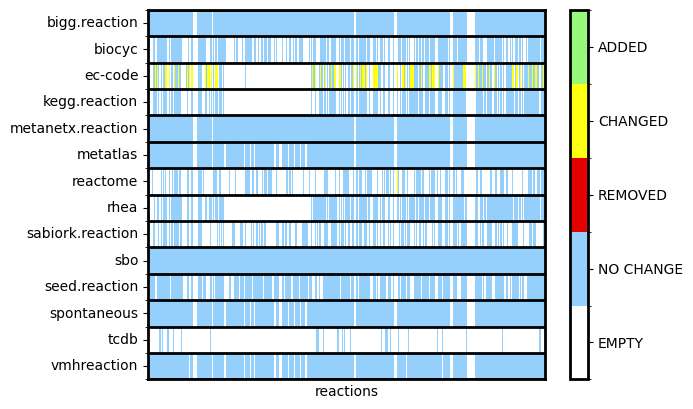

In [6]:
annotation_type = "reactions"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='metabolites'>

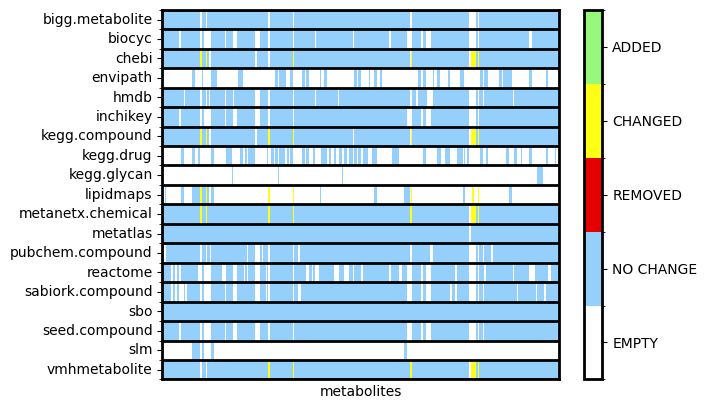

In [7]:
annotation_type = "metabolites"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='genes'>

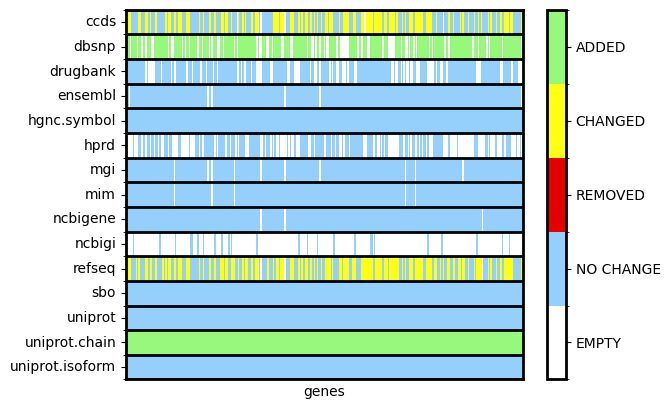

In [8]:
annotation_type = "genes"
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

## Export model

In [9]:
write_rbc_model(model, filetype="all")